# 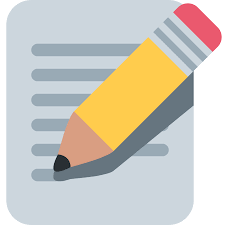 .hocr files to .csv files

This notebook tries to explain how `sol.py` works, so it contains code snippets to let t you play with changes or only explore the solucition before to run it. It is a usefully style of documentation file that let's create some short code experiments and it is nice for presentations too.  

## First idea 💡


The first idea is to make imports of some well known python libraries

- re for regular expretions
- pandas works with data and get the .csv
- bs4 for web scrapping (.horc is like html)
- numpy

### 🧩 Functions Overview

| Function | Purpose | Main Parameters |
|----------|---------|----------------|
| `order_data(data)` | Sorts a list of dictionaries by `'y1'` and `'x1'` in ascending order. | `data` (`list[dict]`) |
| `group_into_rows(data, y_tolerance=10)` | Groups items into rows based on their vertical positions. | `data` (`list[dict]`), `y_tolerance` (`int`, default 10) |
| `detect_columns(rows, x_tolerance=30)` | Detects the most common column positions in a set of rows. | `rows` (`list[list[dict]]`), `x_tolerance` (`int`, default 30) |
| `clean_and_normalize_table(table)` | Cleans a table by removing almost-empty rows and ensures all rows have the same number of columns. | `table` (`list[list[str]]`) |
| `build_csv(rows, output_path='output.csv', x_tolerance=30)` | Builds a CSV from processed rows, aligning items into columns and normalizing the table. | `rows` (`list[list[dict]]`), `output_path` (`str`), `x_tolerance` (`int`) |
| `hocr_to_csv(input_path, output_path='output.csv')` | Full pipeline: converts an HOCR file into a cleaned CSV. | `input_path` (`str`), `output_path` (`str`) |


# NOTE

If you prefer to work with this notebook and do not use `sol.py` next up a code snippet to install the requiremt libraries

In [ ]:
# Install required libraries
!pip install pandas beautifulsoup4 numpy

In [13]:
import re
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np

## 🧩 Function: Parse .hocr file

First we write a function to parse the file, we work with **beautifulSoup4**, this python library solve the problem.
We need to open the file, then we apply `with` but, we are **just reading**, furthermore we set the second param to `r`

In [2]:
def parse_hocr(path):
    with open(path, 'r', encoding='utf-8') as file:
        return BeautifulSoup(file, 'html.parser')

## Finding Text Positions

Function to figure out the text position: Working with regular expretions we can looking for information in the last funtion output, i.e., the soup param. 

- `.hocr`files contains coordinates for the text in the file, so, we save data as list of dictionaries
- `findall`method let us to get all the `horc`tags with `class='ocrx_word'` 

In [3]:
def extract_text_positions(soup):
    data = []
    for span in soup.find_all(class_=['ocrx_word']):
        title = span.get('title', '')
        coords = re.findall(r'bbox (\d+) (\d+) (\d+) (\d+)', title)
        if coords:
            x1, y1, x2, y2 = map(int, coords[0])
            text = span.get_text().strip()
            if text:
                data.append({'text': text, 'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2})
    return data

## 🧩 Function: `order_data(data)`

Sorts a list of dictionaries by the keys `'y1'` and `'x1'` in ascending order.

#### **Description**
This function takes a list of dictionaries (for example, representing coordinates or positioned elements)
and returns it sorted. The data is first sorted by `'y1'`, and in case of ties, by `'x1'`.

It’s useful when working with spatial data, text layout coordinates, 
or any two-dimensional structure where ordering matters.

#### **Parameters**
| Name | Type | Description |
|------|------|-------------|
| `data` | `list[dict]` | A list of dictionaries containing at least the keys `'y1'` and `'x1'`. |

#### **Returns**
| Type | Description |
|------|-------------|
| `list[dict]` | A new list sorted according to `'y1'` and `'x1'`. |


In [4]:
def order_data(data):
    return sorted(data, key=lambda item: (item['y1'], item['x1']))

## 🧩 Function: `group_into_rows(data, y_tolerance=10)`

This function helps you organize your extracted data into rows based on their vertical positions.  
It looks at each element’s `y1` coordinate and groups together items that are close to each other,  
according to a given `y_tolerance` value.

So, if two elements have similar `y1` values (within the tolerance range),  
they’ll be placed in the same row — just like how text lines appear on a page.

#### **Parameters**
- `data` (`list[dict]`): The list of items (each one containing a `y1` key).
- `y_tolerance` (`int`, default `10`): The maximum allowed vertical difference for items to belong to the same row.

#### **Returns**
- `list[list[dict]]`: A list of rows, where each row is a list of items grouped by their `y1` proximity.


In [5]:
def group_into_rows(data, y_tolerance=10):
    rows = []
    current_row = []
    last_y = None

    for item in data:
        if last_y is None or abs(item['y1'] - last_y) <= y_tolerance:
            current_row.append(item)
        else:
            rows.append(current_row)
            current_row = [item]
        last_y = item['y1']
    if current_row:
        rows.append(current_row)
    return rows


## 🧩 Function: `detect_columns(rows, x_tolerance=30)`

This function helps you find the most common column positions in a set of rows.  
It looks at the `x1` positions of all items in all rows and groups together values that are close to each other,  
based on the `x_tolerance` you set.  

The result is a list of integer positions representing the main columns,  
so you can later align or process your data by these detected columns.

#### **Parameters**
- `rows` (`list[list[dict]]`): A list of rows, where each row is a list of items containing at least the key `'x1'`.  
- `x_tolerance` (`int`, default `30`): Maximum horizontal difference to consider values part of the same column group.

#### **Returns**
- `list[int]`: A list of integer positions representing the main columns detected from the rows.


In [6]:
def detect_columns(rows, x_tolerance=30):
    """Encuentra las posiciones de columna más comunes."""
    x_positions = []
    for row in rows:
        for cell in row:
            x_positions.append(cell['x1'])
    x_positions = sorted(x_positions)
    
    # Agrupamos valores cercanos en rangos
    columns = []
    current_group = [x_positions[0]]
    for x in x_positions[1:]:
        if abs(x - np.mean(current_group)) <= x_tolerance:
            current_group.append(x)
        else:
            columns.append(int(np.mean(current_group)))
            current_group = [x]
    columns.append(int(np.mean(current_group)))
    return columns


## 🧩 Function: `clean_and_normalize_table(table)`

This function helps you clean and standardize a table represented as a list of rows.  
It removes empty or almost-empty rows, and then makes sure all rows have the same number of columns by filling missing cells with empty strings.  

This is useful to prepare your data for further processing or CSV export,  
so that all rows have a consistent structure.

#### **Parameters**
- `table` (`list[list[str]]`): A list of rows, where each row is a list of cell values (strings).

#### **Returns**
- `list[list[str]]`: A cleaned and normalized table where all rows have the same number of columns.


In [7]:
def clean_and_normalize_table(table):
    # Elimina filas vacías o casi vacías
    cleaned = [row for row in table if sum(1 for cell in row if cell.strip()) > 1]
    # Encuentra el máximo número de columnas
    max_cols = max(len(row) for row in cleaned)
    # Normaliza el número de columnas
    normalized = [row + [''] * (max_cols - len(row)) for row in cleaned]
    return normalized


## 🧩 Function: `build_csv(rows, output_path='output.csv', x_tolerance=30)`

This function takes processed rows of data and generates a CSV file.  
It first detects the main column positions using `detect_columns`, then organizes each row into these columns.  
If multiple items fall into the same column, their text is combined with a space.  

After constructing the table, it cleans and normalizes it so all rows have the same number of columns,  
and finally saves it as a CSV file at the specified output path.  

#### **Parameters**
- `rows` (`list[list[dict]]`): A list of rows, where each row is a list of items containing at least `'x1'` and `'text'`.  
- `output_path` (`str`, default `'output.csv'`): The path where the generated CSV file will be saved.  
- `x_tolerance` (`int`, default `30`): Maximum horizontal difference to consider values part of the same column group.

#### **Returns**
- `None`: The function writes the CSV to disk and prints a confirmation message.


In [8]:
def build_csv(rows, output_path='output.csv', x_tolerance=30):
    columns = detect_columns(rows, x_tolerance)
    table = []

    for row in rows:
        line = [''] * len(columns)
        for cell in row:
            x = cell['x1']
            idx = min(range(len(columns)), key=lambda i: abs(columns[i] - x))
            if line[idx]:
                line[idx] += ' ' + cell['text']
            else:
                line[idx] = cell['text']
        table.append(line)

    # Limpieza y normalización
    table = clean_and_normalize_table(table)

    df = pd.DataFrame(table)
    df.to_csv(output_path, index=False, header=False)
    print(f"CSV generado: {output_path}")


## 🧩 Function: `hocr_to_csv(input_path, output_path='output.csv')`

This function is the main pipeline to convert an `.horc` file into a `.csv`.  
It parses the `.horc` file, extracts the text with its positions, orders the items, groups them into rows,  
and finally builds a cleaned and normalized `.csv` file at the specified location.  

#### **Parameters**
- `input_path` (`str`): The path to the HOCR file to be processed.  
- `output_path` (`str`, default `'output.csv'`): The path where the resulting CSV file will be saved.

#### **Returns**
- `None`: The function runs the full processing pipeline and writes the CSV to disk.


In [9]:
def hocr_to_csv(input_path, output_path='output.csv'):
    soup = parse_hocr(input_path)
    data = extract_text_positions(soup)
    ordered = order_data(data)
    rows = group_into_rows(ordered)
    build_csv(rows, output_path)


## 🧠 Example and Request Process

Below, you can experiment with the previously defined Python functions to generate as many `.csv` files as you need.  
Start with a `list` of file names and iterate through it by applying the `hocr_to_csv` function.

> 💡 **Note:** You can change the output directory by modifying the corresponding variable in the code.


In [14]:
names = ['1C_5.hocr', '1E_1.hocr', '3T_4.hocr']
for name in names:
    hocr_input = 'files/hocr_files/' + name
    csv_output = 'files/csv_files/' + name[:4] + '.csv'
    hocr_to_csv(hocr_input, csv_output)

CSV generado: files/csv_files/1C_5.csv
CSV generado: files/csv_files/1E_1.csv
CSV generado: files/csv_files/3T_4.csv
